# 주식채권현금 평균모멘텀스코어 분산투자 한국 그림 2-33
- 투자 기간 : 2002년 1월~2017월 6일
- 투자 대상 : 코스피200지수, 10년 만기 국고채 지수, 20년 만기 국고채 지수, 현금(3년 만기 국고채 지수)
- 매수 규칙 : 주식:채권:현금=코스피200지수 최근 12개월 평균 모멘텀 스코어 10년(20년) 만기 국고채 지수 최근 12개월 평균 모멘텀 스코어 : 1(현금 모멘텀)
- 매도 규칙 : 매달 말 위의 투자 비중을 새로 계산하여 주식:채권:현금 투자 비중을 조절하여 반복
- 동일 비중 
  - 20년 국채 9.1%/-15.1%

In [1]:
from settings import *

## 데이타 읽기

In [2]:
tickers = ['kodex200', 'kbond3y', 'kbond10y', 'kbond20y']
read_df = get_data()
read_df = read_df[tickers]
read_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5433 entries, 2000-01-04 to 2021-12-30
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   kodex200  5433 non-null   float64
 1   kbond3y   5433 non-null   float64
 2   kbond10y  5433 non-null   float64
 3   kbond20y  5433 non-null   float64
dtypes: float64(4)
memory usage: 212.2 KB


In [3]:
data = read_df['2001':].copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5192 entries, 2001-01-02 to 2021-12-30
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   kodex200  5192 non-null   float64
 1   kbond3y   5192 non-null   float64
 2   kbond10y  5192 non-null   float64
 3   kbond20y  5192 non-null   float64
dtypes: float64(4)
memory usage: 202.8 KB


## 전략 Class 생성

In [4]:
# 월말에 계산하고 다음월 첫 거래일 종가로 거래 한다고 전재
# 12개월 평균모멘텀스코어 계산

class WeighAMS(bt.Algo):
    def __init__(self, lags, months):
        super(WeighAMS, self).__init__()
        self.lags = lags
        self.months = months

    def 평균모멘텀스코어(self, 데이터, 개월):
        초기값 = 0
        for i in range(1, 개월+1):
            초기값 += np.where(데이터 / 데이터.shift(i) > 1, 1, 0)
        return 초기값[-1]/개월

    def AMS(self, prc):
        ''' x : Series (DataFrame의 컬럼)
            x[-1] : 기준일. x의 현재값
            (오늘날짜/과거날짜 - 1) > 0 보다 크면 1, 아니면 0
            => 오늘날짜/과거날짜 > 1 => 오늘날짜 > 과거날짜  => x[-1] > x
        '''
        average_momentum_score = pd.Series(dtype='float64')
        # print(f"{list(np.where(x[-1]>x, 1, 0)[:-1])}, {len(np.where(x[-1]>x, 1, 0)[:-1])}")
        for c in prc.columns:
            average_momentum_score[c] = np.mean(np.where(prc[c][-1]>prc[c], 1, 0)[:-1])# 당일 날짜 비교는 제외해준다 [:-1]

        return average_momentum_score

    def __call__(self, target):
        selected = target.temp['selected'].copy()

        t0 = (target.now - pd.DateOffset(months=self.lags)).strftime("%Y-%m")
        start = (target.now - pd.DateOffset(months=self.lags) - pd.DateOffset(months=self.months)).strftime("%Y-%m")

        print(f"\nprc : {target.now} {t0} ~ {start}")
        prc = target.universe[selected].loc[start:t0].resample('M').last()
        if (len(prc) < self.months+1):
            return False

        weights = pd.Series(self.AMS(prc), index=selected)
        weights = weights/weights.sum()

#         print(self.평균모멘텀스코어(prc, self.months), prc)
        target.temp['weights'] = weights

        return True

## 전략 생성

In [5]:
# 매월 초 
# lags 1은 한달 전  ~ 13개월전 평균 모멘텀 스코어
def average_momentum_score_strategy(name, data, tickers, lags=1, months=12):
    st = bt.Strategy(name,
        [
            bt.algos.RunMonthly(run_on_first_date=True,
                                run_on_end_of_period=False, #월초
                                run_on_last_date=False),
            bt.algos.SelectThese(tickers),
            WeighAMS(lags, months), # lags=0이면 위와 같다.
            PrintTempWeights(),
            bt.algos.Rebalance()
        ]
    )
    return bt.Backtest(st, data, initial_capital=100000000)

## 전략 실행

In [6]:
bt_kospi = long_only_ew(data, ['kodex200'], 'kodex200')
bt_10 = average_momentum_score_strategy('10년국채모멘텀', data, 
                                        ['kodex200', 'kbond3y', 'kbond10y'])
bt_20 = average_momentum_score_strategy('20년국채모멘텀', data, 
                                        ['kodex200', 'kbond3y', 'kbond20y'])

r10 = bt.run(bt_10)


prc : 2001-01-02 00:00:00 2000-12 ~ 1999-12

prc : 2001-02-01 00:00:00 2001-01 ~ 2000-01

prc : 2001-03-02 00:00:00 2001-02 ~ 2000-02

prc : 2001-04-02 00:00:00 2001-03 ~ 2000-03

prc : 2001-05-02 00:00:00 2001-04 ~ 2000-04

prc : 2001-06-01 00:00:00 2001-05 ~ 2000-05

prc : 2001-07-02 00:00:00 2001-06 ~ 2000-06

prc : 2001-08-01 00:00:00 2001-07 ~ 2000-07

prc : 2001-09-03 00:00:00 2001-08 ~ 2000-08

prc : 2001-10-04 00:00:00 2001-09 ~ 2000-09

prc : 2001-11-01 00:00:00 2001-10 ~ 2000-10

prc : 2001-12-03 00:00:00 2001-11 ~ 2000-11

prc : 2002-01-02 00:00:00 2001-12 ~ 2000-12

prc : 2002-02-01 00:00:00 2002-01 ~ 2001-01
2002-02-01 00:00:00 10년국채모멘텀 kodex200:0.400 kbond3y:0.367 kbond10y:0.233 

prc : 2002-03-04 00:00:00 2002-02 ~ 2001-02
2002-03-04 00:00:00 10년국채모멘텀 kodex200:0.353 kbond3y:0.353 kbond10y:0.294 

prc : 2002-04-01 00:00:00 2002-03 ~ 2001-03
2002-04-01 00:00:00 10년국채모멘텀 kodex200:0.462 kbond3y:0.423 kbond10y:0.115 

prc : 2002-05-02 00:00:00 2002-04 ~ 2001-04
2002-05-02 00

In [7]:
r20 = bt.run(bt_20)
r_kospi = bt.run(bt_kospi)
r = bt.run(bt_10, bt_20, bt_kospi)


prc : 2001-01-02 00:00:00 2000-12 ~ 1999-12

prc : 2001-02-01 00:00:00 2001-01 ~ 2000-01

prc : 2001-03-02 00:00:00 2001-02 ~ 2000-02

prc : 2001-04-02 00:00:00 2001-03 ~ 2000-03

prc : 2001-05-02 00:00:00 2001-04 ~ 2000-04

prc : 2001-06-01 00:00:00 2001-05 ~ 2000-05

prc : 2001-07-02 00:00:00 2001-06 ~ 2000-06

prc : 2001-08-01 00:00:00 2001-07 ~ 2000-07

prc : 2001-09-03 00:00:00 2001-08 ~ 2000-08

prc : 2001-10-04 00:00:00 2001-09 ~ 2000-09

prc : 2001-11-01 00:00:00 2001-10 ~ 2000-10

prc : 2001-12-03 00:00:00 2001-11 ~ 2000-11

prc : 2002-01-02 00:00:00 2001-12 ~ 2000-12

prc : 2002-02-01 00:00:00 2002-01 ~ 2001-01
2002-02-01 00:00:00 20년국채모멘텀 kodex200:0.444 kbond3y:0.407 kbond20y:0.148 

prc : 2002-03-04 00:00:00 2002-02 ~ 2001-02
2002-03-04 00:00:00 20년국채모멘텀 kodex200:0.353 kbond3y:0.353 kbond20y:0.294 

prc : 2002-04-01 00:00:00 2002-03 ~ 2001-03
2002-04-01 00:00:00 20년국채모멘텀 kodex200:0.462 kbond3y:0.423 kbond20y:0.115 

prc : 2002-05-02 00:00:00 2002-04 ~ 2001-04
2002-05-02 00

In [8]:
start = '2002-02-01'
e = '2017-6-30'

In [9]:
r.set_date_range(start)
r.display()

Stat                 10년국채모멘텀    20년국채모멘텀    kodex200
-------------------  ----------------  ----------------  ----------
Start                2002-02-01        2002-02-01        2002-02-01
End                  2021-12-30        2021-12-30        2021-12-30
Risk-free rate       0.00%             0.00%             0.00%

Total Return         256.30%           358.22%           511.99%
Daily Sharpe         1.03              1.09              0.53
Daily Sortino        1.64              1.77              0.85
CAGR                 6.59%             7.95%             9.53%
Max Drawdown         -10.37%           -10.70%           -52.67%
Calmar Ratio         0.64              0.74              0.18

MTD                  2.76%             2.65%             6.52%
3m                   -3.18%            -3.35%            -0.81%
6m                   -7.77%            -8.21%            -9.05%
YTD                  -0.47%            -0.61%            2.77%
1Y                   -0.47%            -0.61

In [10]:
r.set_date_range(start, e)
r.display()

Stat                 10년국채모멘텀    20년국채모멘텀    kodex200
-------------------  ----------------  ----------------  ----------
Start                2002-02-01        2002-02-01        2002-02-01
End                  2017-06-30        2017-06-30        2017-06-30
Risk-free rate       0.00%             0.00%             0.00%

Total Return         208.16%           282.46%           341.90%
Daily Sharpe         1.23              1.26              0.55
Daily Sortino        1.98              2.07              0.87
CAGR                 7.58%             9.10%             10.12%
Max Drawdown         -8.81%            -10.59%           -52.67%
Calmar Ratio         0.86              0.86              0.19

MTD                  1.07%             1.04%             2.42%
3m                   5.64%             5.74%             11.36%
6m                   10.78%            11.06%            20.96%
YTD                  10.78%            11.06%            20.96%
1Y                   12.29%            10.

In [11]:
r.prices.to_drawdown_series().describe()

,10년국채모멘텀,20년국채모멘텀,kodex200
count,3817.000,3817.000,3817.000
mean,-0.019,-0.020,-0.123
std,0.019,0.022,0.098
min,-0.088,-0.106,-0.527
25%,-0.029,-0.032,-0.162
50%,-0.013,-0.012,-0.108
75%,-0.003,-0.003,-0.057
max,0.000,0.000,0.000


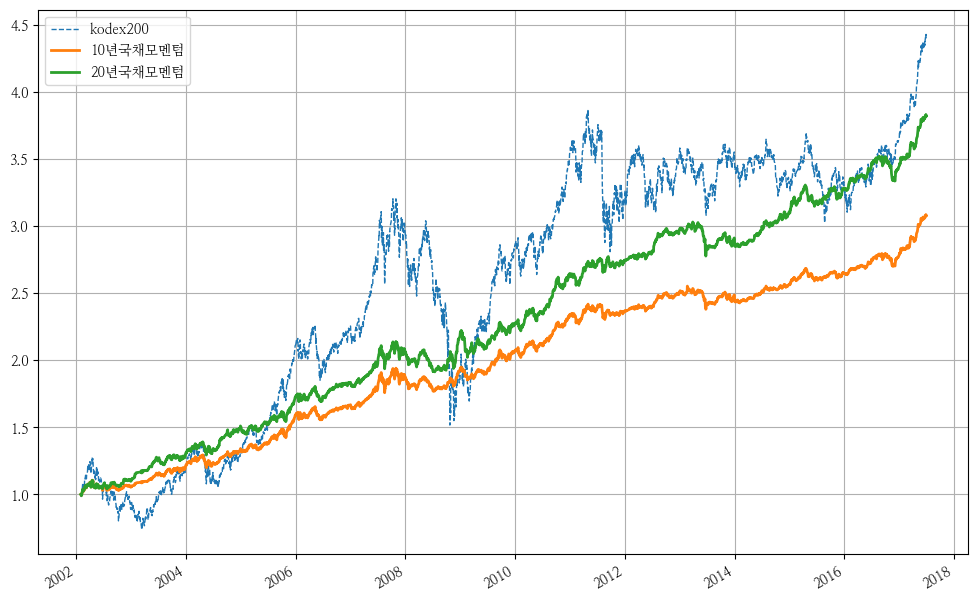

In [14]:
r_kospi.set_date_range(start,e)
r10.set_date_range(start,e)
r20.set_date_range(start,e)

ax1 = r_kospi.prices.rebase(1).plot(ls='--', figsize=(12, 8));
r10.prices.rebase(1).plot(ax=ax1, lw=2, figsize=(12, 8));
r20.prices.rebase(1).plot(ax=ax1, lw=2, figsize=(12, 8));